In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

### Time to get your hands dirty. Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

Some figures from the second paper:


SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 
    

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new it's computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


# Code

## 1) Extracting data

Extract the fluxes

In [2]:
data = np.genfromtxt('../solutions/galaxyquasar.csv', delimiter=',', names=True, usecols=(0,1,2,3,4,6), dtype=float)
names = data.dtype.names
names

('u', 'g', 'r', 'i', 'z', 'z1')

In [3]:
data = np.genfromtxt('../solutions/galaxyquasar.csv', delimiter=',', skip_header=1, usecols=(0,1,2,3,4,6), dtype=float)
data = dict(zip(names, data.T))
data

{'u': array([18.97213, 19.24592, 19.43536, ..., 18.62718, 19.5514 , 18.80772]),
 'g': array([18.53676, 17.47646, 17.70268, ..., 17.30876, 18.27711, 17.75751]),
 'r': array([18.5828 , 16.47817, 16.91565, ..., 16.87371, 17.62101, 17.405  ]),
 'i': array([18.34936, 16.04472, 16.58327, ..., 16.62399, 17.21947, 17.2165 ]),
 'z': array([18.29215, 15.68851, 16.39128, ..., 16.42296, 17.03347, 17.12295]),
 'z1': array([0.5228189 , 0.1228459 , 0.        , ..., 0.05442934, 0.1125709 ,
        0.04365238])}

Extract the labels

In [4]:
labels = np.genfromtxt('../solutions/galaxyquasar.csv', delimiter=',', skip_header=1, usecols=5, dtype=str)
print(f'labels: {labels}')
print(f'{np.sum(labels=="GALAXY")} galaxies')
print(f'{np.sum(labels=="QSO")} quasars')

le = LabelEncoder()
labels = le.fit_transform(labels)
class_names = le.classes_
print(f'\nencoded labels: {labels}')
print(f'class names:{class_names}')

labels: ['QSO' 'GALAXY' 'GALAXY' ... 'GALAXY' 'GALAXY' 'GALAXY']
42866 galaxies
7134 quasars

encoded labels: [1 0 0 ... 0 0 0]
class names:['GALAXY' 'QSO']


Create an array of the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors

In [5]:
data['ug'] = data['u'] - data['g'] 
data['gr'] = data['g'] - data['r'] 
data['ri'] = data['r'] - data['i'] 
data['iz'] = data['i'] - data['z'] 
data['labels'] = labels
data.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'z1', 'ug', 'gr', 'ri', 'iz', 'labels'])

## 2) Exploring the data

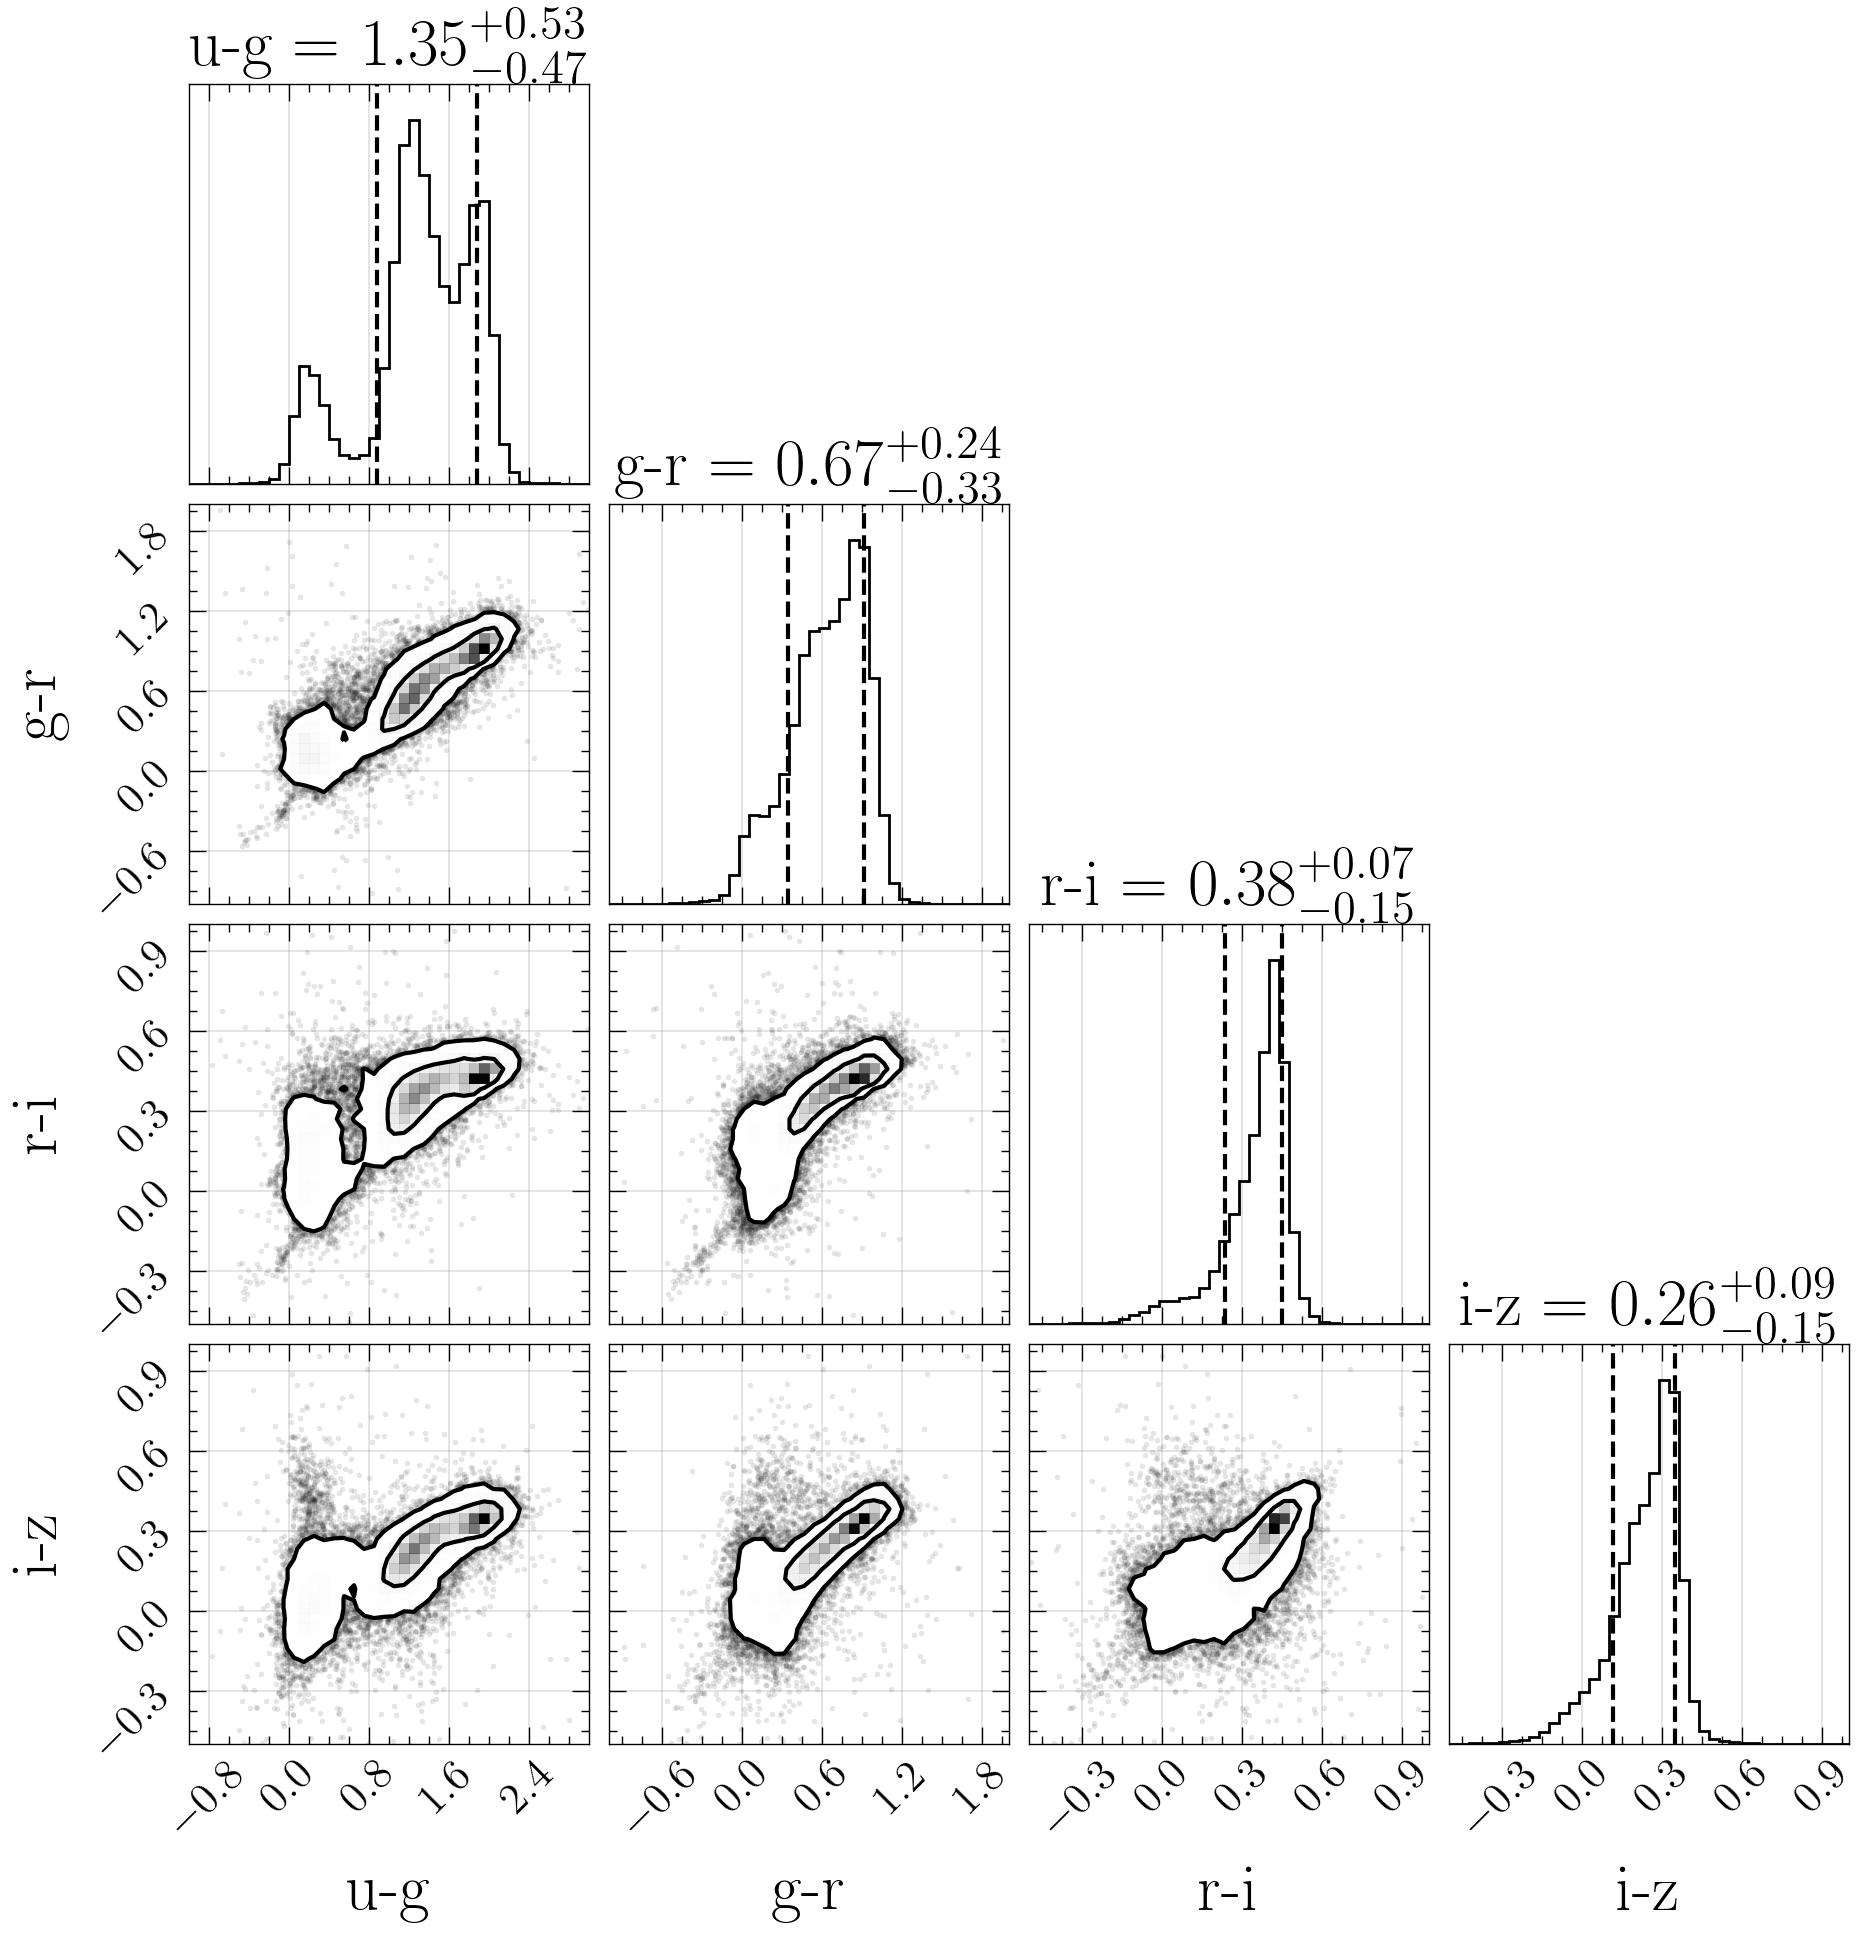

In [6]:
import corner

fig = corner.corner(np.array([data['ug'], data['gr'], data['ri'], data['iz']]).T, 
                    range=[[-1, 3], [-1, 2], [-0.5, 1], [-0.5, 1]], 
                    bins=40, 
                    quantiles=(0.16, 0.84), 
                    levels=(0.68, 0.95), 
                    show_titles=True, 
                    labels=['u-g', 'g-r', 'r-i', 'i-z'])

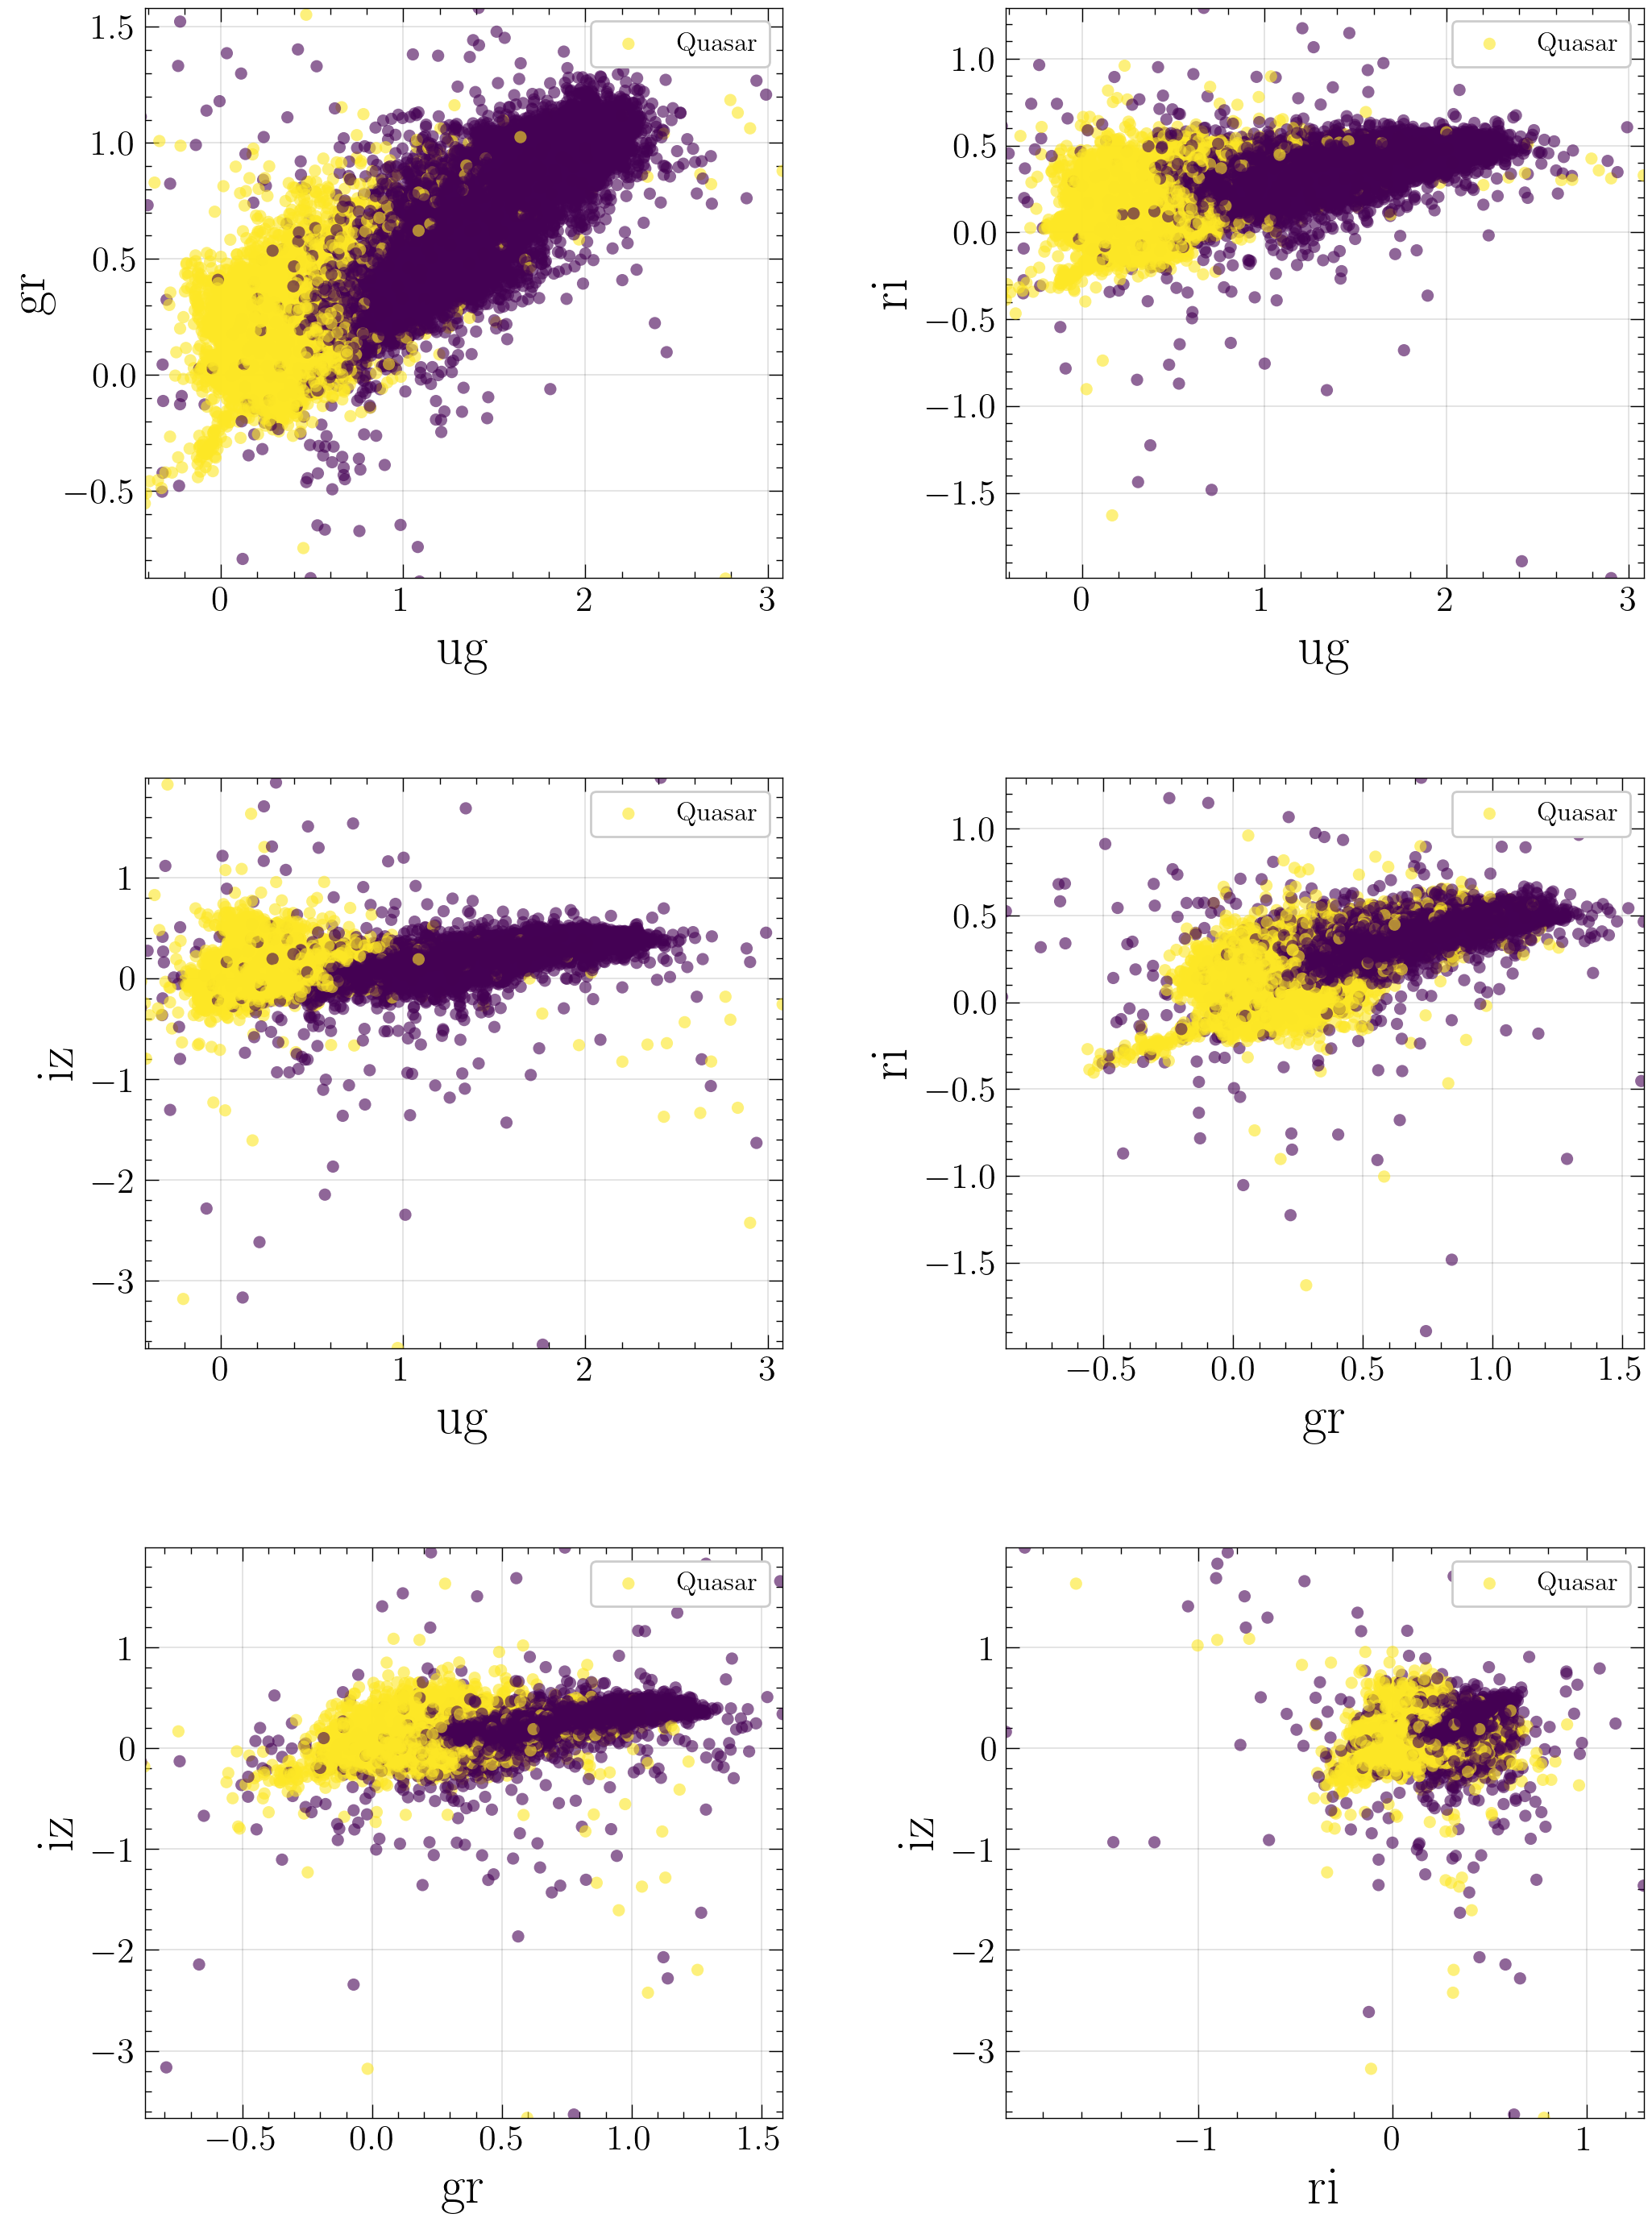

In [7]:
fig = plt.figure(figsize=(12, 17))
fig.subplots_adjust(hspace=0.35, wspace=0.35)

for i, color in enumerate(itertools.combinations(['ug', 'gr', 'ri', 'iz'], r=2)):

    color1, color2 = color

    ax = fig.add_subplot(321 + i)
    ax.scatter(data[color1], data[color2], c=data['labels'], s=30, alpha=0.6, linewidths=0, label='Quasar')
    ax.set_xlim(np.quantile(data[color1], [0.0005, 0.9995]))
    ax.set_ylim(np.quantile(data[color2], [0.0005, 0.9995]))
    ax.set_xlabel(color1)
    ax.set_ylabel(color2)
    ax.legend(fontsize=12, loc='upper right');

The `u-g` color most evidently displays a bimodal distribution.\
We start our classification attemp with only 2 dimensions, and then we can try to add other colors and see what happens.\
Let's start with the `u-g , r-i` plane, since it's far less correlated than `u-g , g-r`.

## 3) Classification

In [8]:
Ncolors = np.arange(2, 5)
Ncolors

array([2, 3, 4])

In [9]:
X = np.array([data['ug'], data['ri'], data['gr'], data['iz']]).T
y = data['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

### 3.0) Function

In [10]:
def Classify(clf, X, X_train, X_test, y_train, y_test):
    # CLASSIFICATION
    y_pred = np.zeros(shape=(len(X_test),3))
    y_prob = np.zeros(shape=(len(X_test),3))
    completeness = np.zeros(3)
    contamination = np.zeros(3)
    
    for i in range(len(Ncolors)):
        clf.fit(X_train[:,:Ncolors[0]+i], y_train)
        y_pred[:,i] = clf.predict(X_test[:,:Ncolors[0]+i])
        y_prob[:,i] = clf.predict_proba(X_test[:,:Ncolors[0]+i])[:,1]
        completeness[i], contamination[i] = completeness_contamination(y_pred[:,i], y_test)
    
    # -------------------------------------------------------------------------------------------------------------
    
    # PLOTS
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[1.5, 1])

    # Left plot
    ax = fig.add_subplot(gs[:, 0])
    ax.scatter(X[:,0], X[:,1], c=y, s=30, alpha=0.6, linewidths=0, label='Quasar')
    
    xlim = (np.quantile(X[:,0], [0.0005, 0.9995]))
    ylim = (np.quantile(X[:,1], [0.0005, 0.9995]))

    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
    clf.fit(X_train[:,:Ncolors[0]], y_train)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)
    ax.contour(xx, yy, Z, [0.5], colors='k')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('u-g')
    ax.set_ylabel('r-i')
    ax.legend()
    
    
    # Right plots
    ax = fig.add_subplot(gs[0, 1])
    ax.plot(Ncolors, completeness, 'o-k', ms=6)
    ax.set_ylim(0.92, 0.97)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylabel('Completeness')
    
    ax = fig.add_subplot(gs[1, 1])
    ax.plot(Ncolors, contamination, 'o-k', ms=6)
    ax.set_ylim(0, 0.15)
    ax.set_xlabel('N colors')
    ax.set_ylabel('Contamination')
    
    return fig, y_pred, y_prob, completeness, contamination

### 3.1) Gaussian Naive Bayes

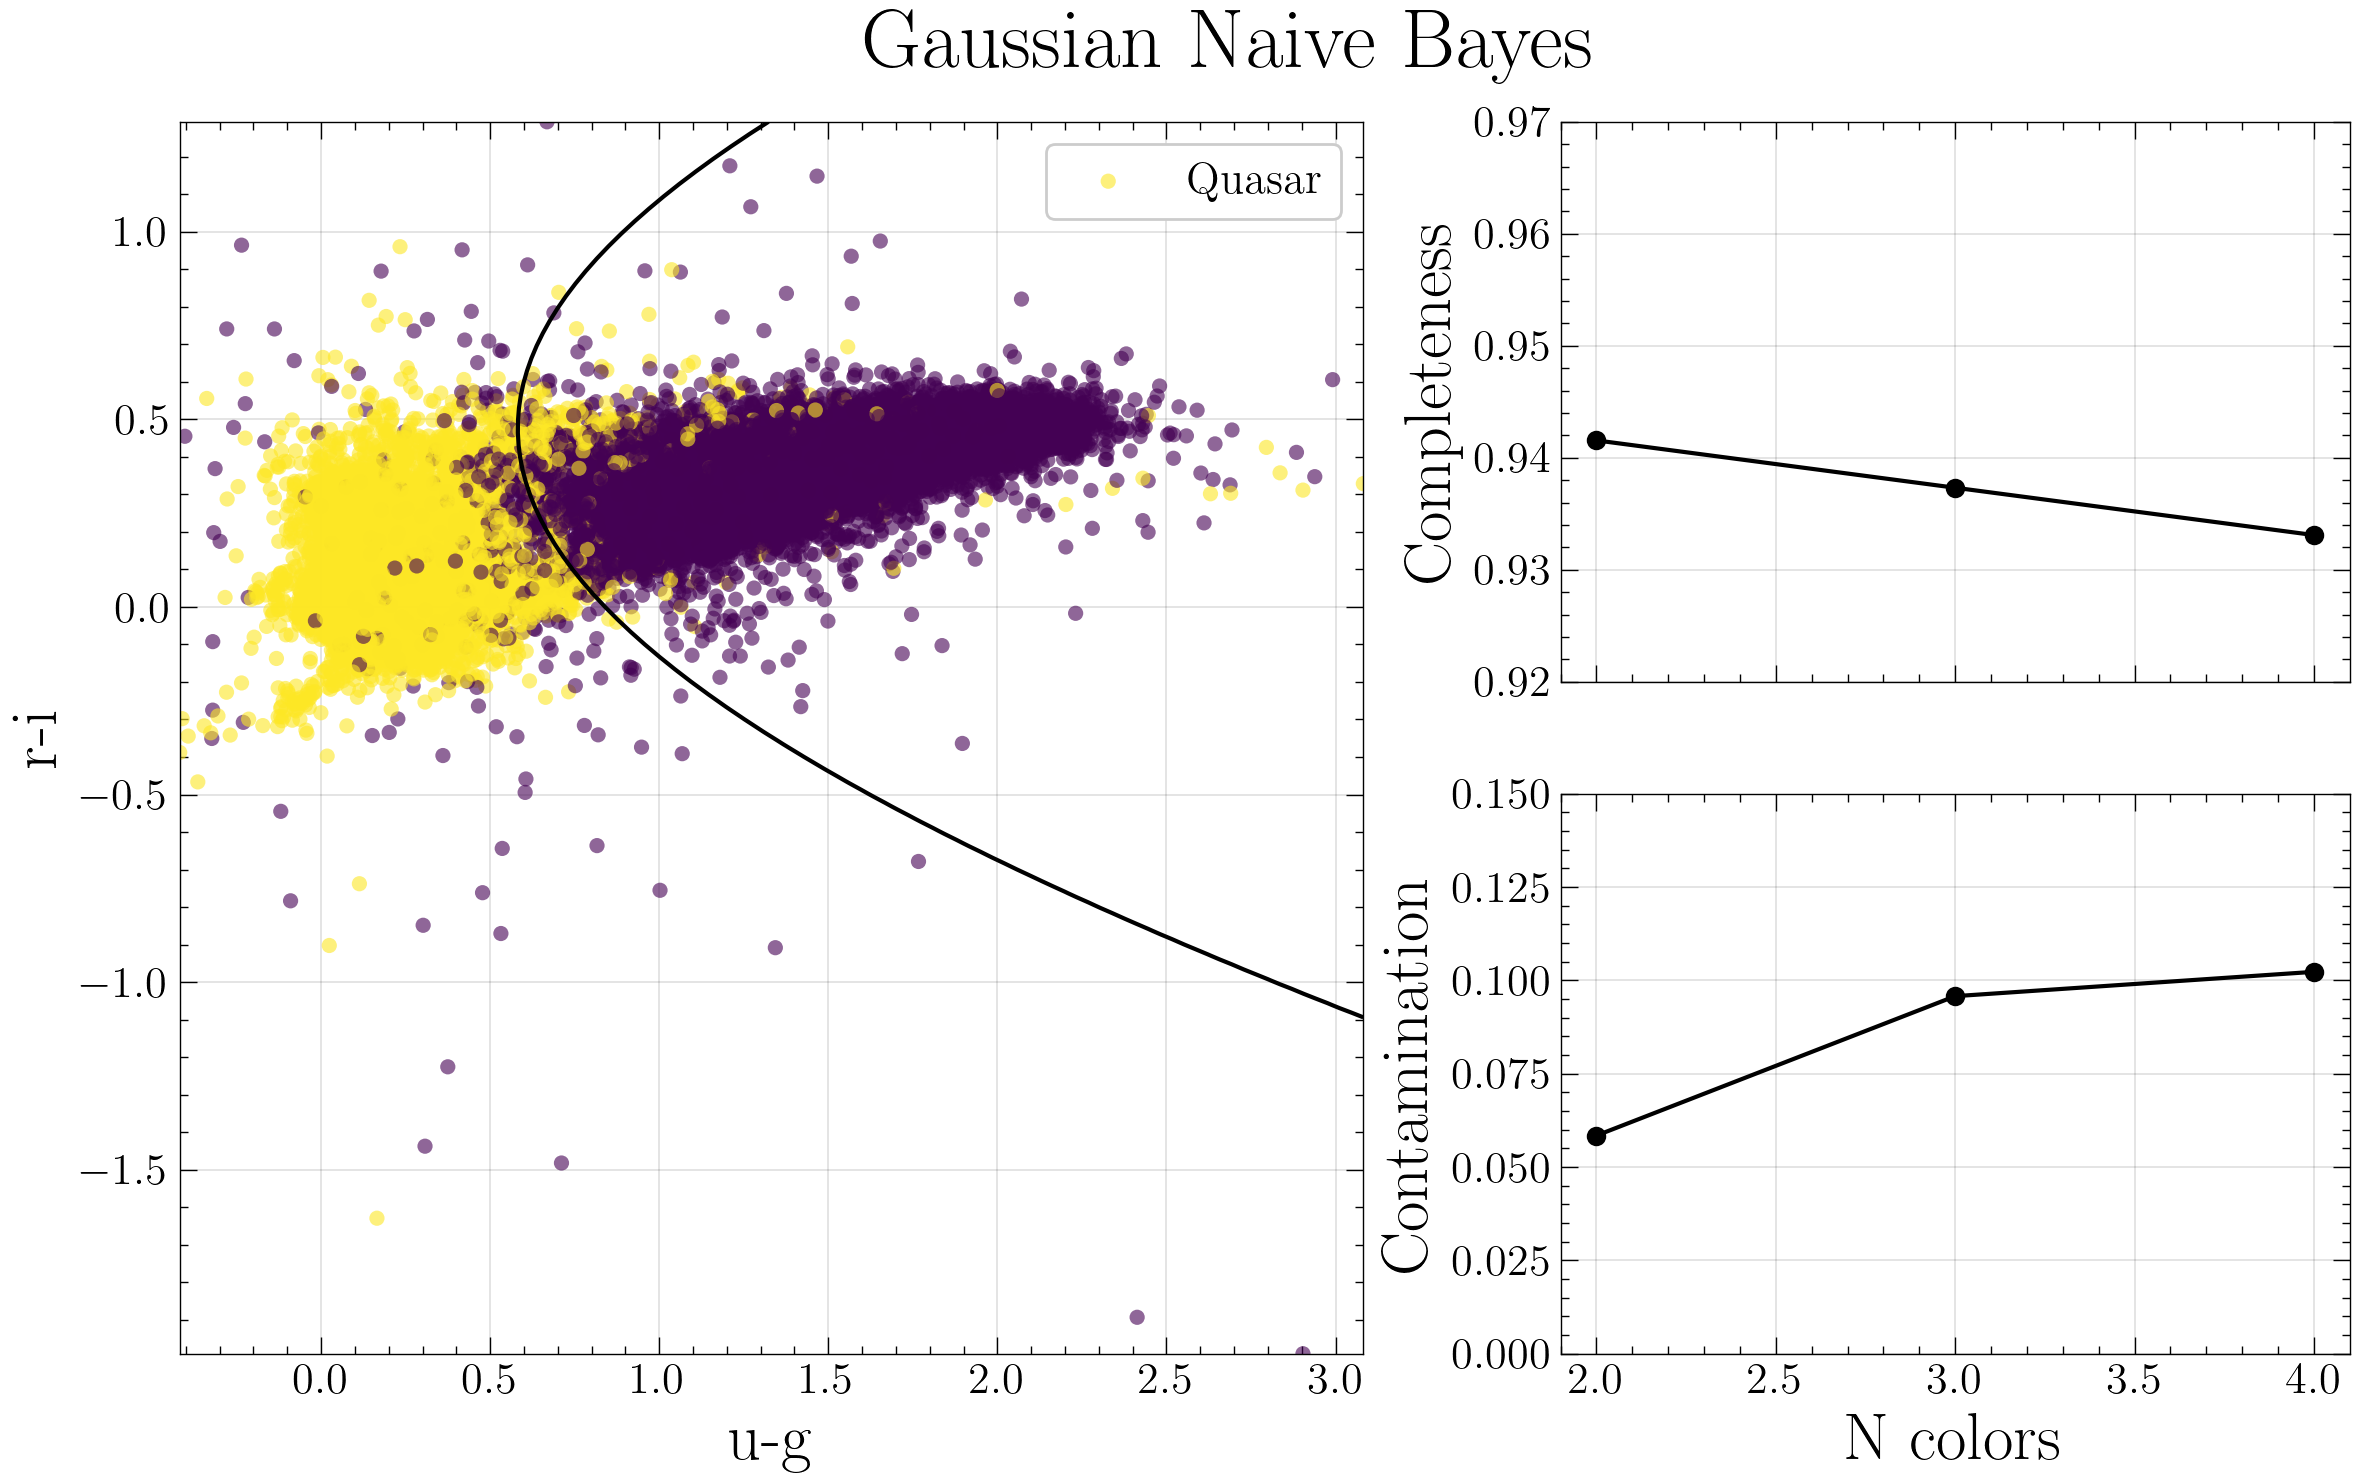

In [11]:
gnb = GaussianNB()

fig, gnb_y_pred, gnb_y_prob, gnb_completeness, gnb_contamination = Classify(gnb, X, X_train, X_test, y_train, y_test)
fig.suptitle('Gaussian Naive Bayes', fontsize=30, y=0.95);

### 3.2) Linear Discriminant Analysis

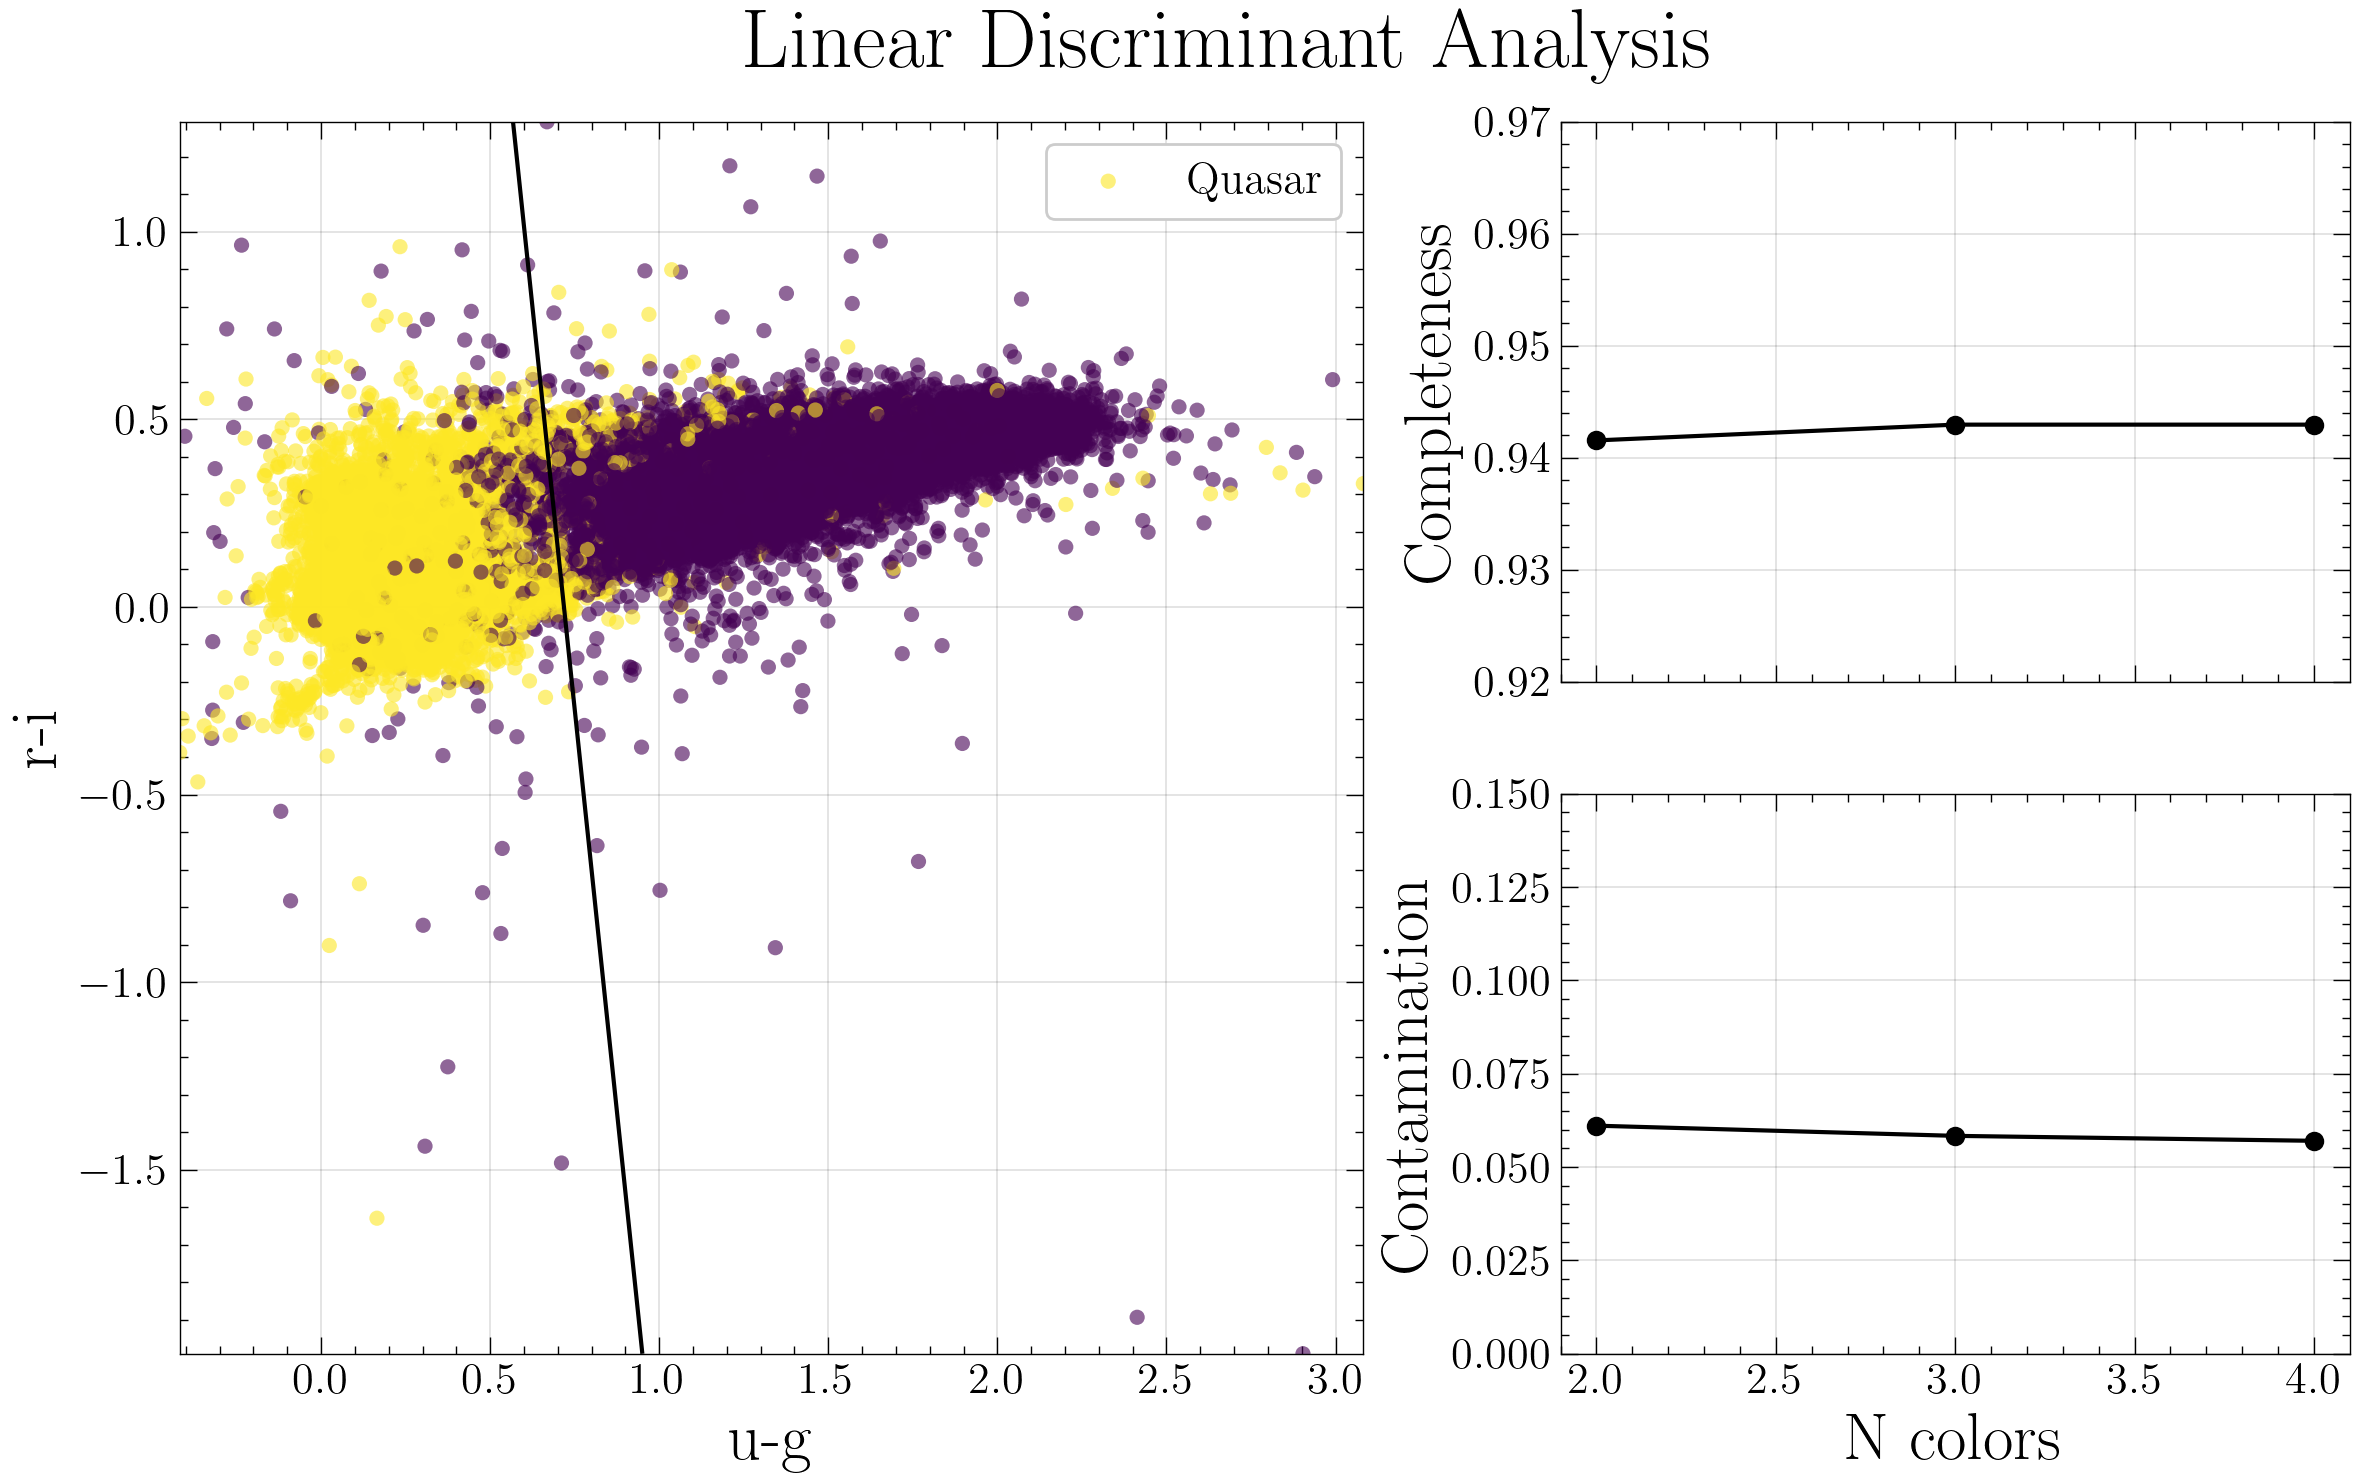

In [12]:
lda = LinearDiscriminantAnalysis()

fig, lda_y_pred, lda_y_prob, lda_completeness, lda_contamination = Classify(lda, X, X_train, X_test, y_train, y_test)
fig.suptitle('Linear Discriminant Analysis', fontsize=30, y=0.95);

### 3.3) Quadratic Discriminant Analysis

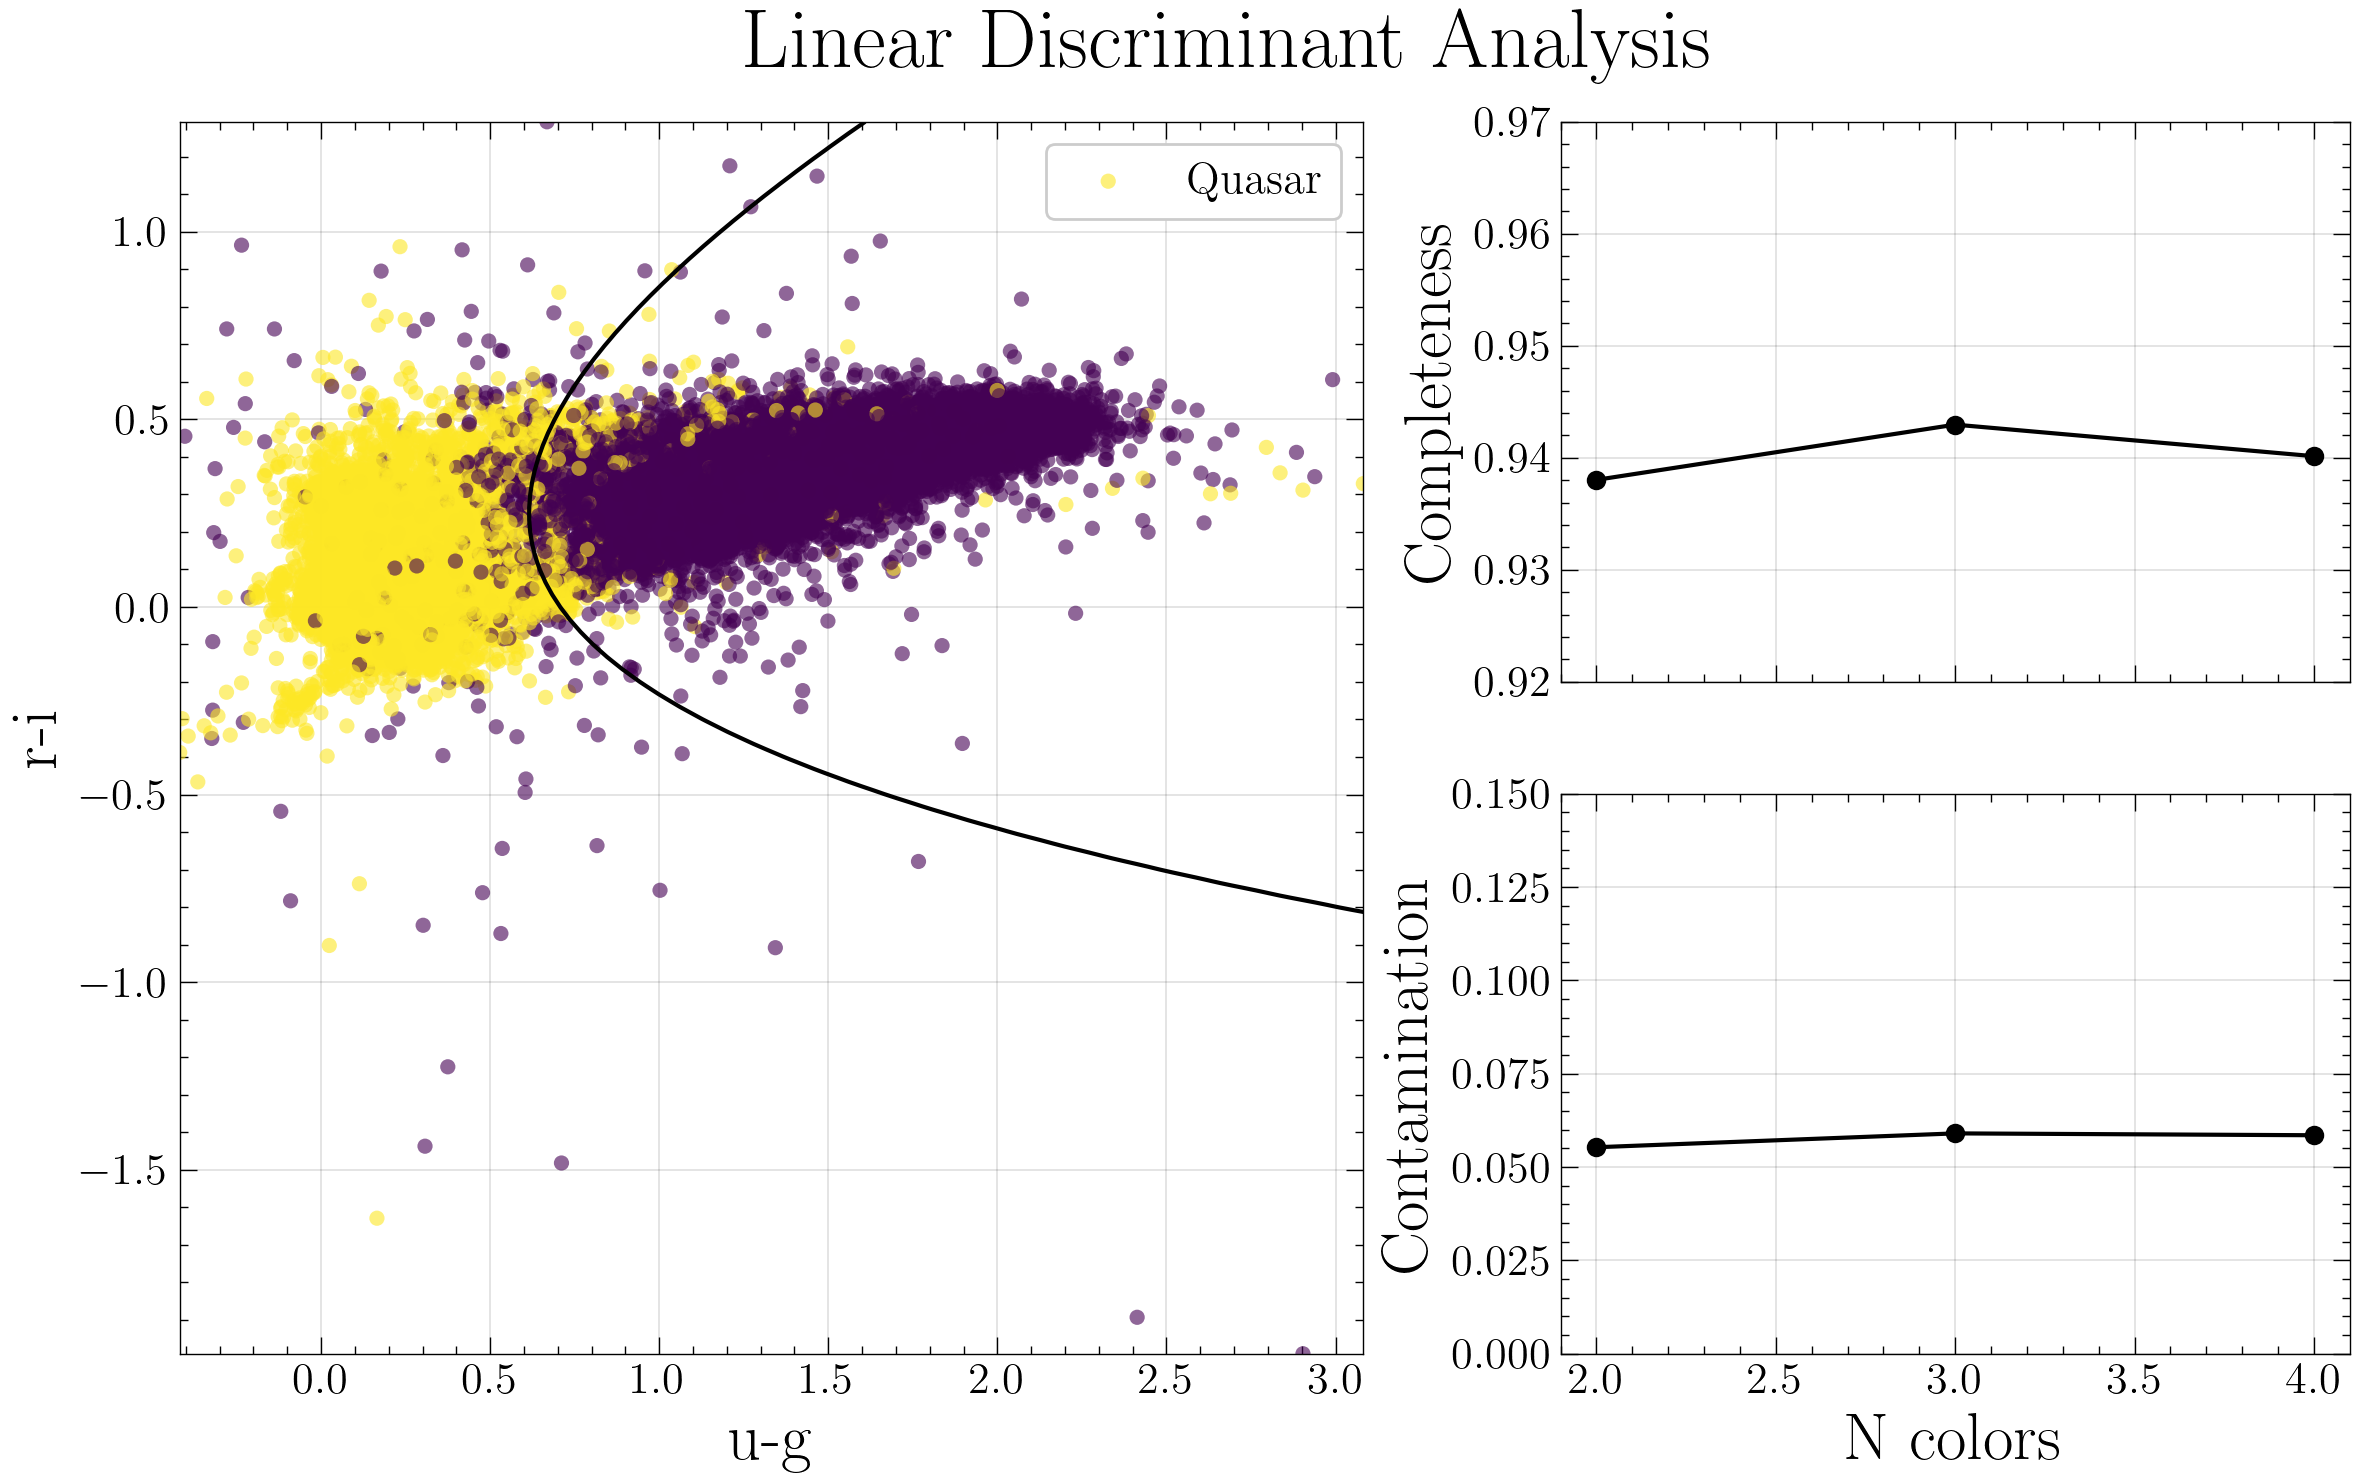

In [13]:
qda = QuadraticDiscriminantAnalysis()

fig, qda_y_pred, qda_y_prob, qda_completeness, qda_contamination = Classify(qda, X, X_train, X_test, y_train, y_test)
fig.suptitle('Linear Discriminant Analysis', fontsize=30, y=0.95);

### 3.4) Gaussian-Mixture-Model Bayes Classification

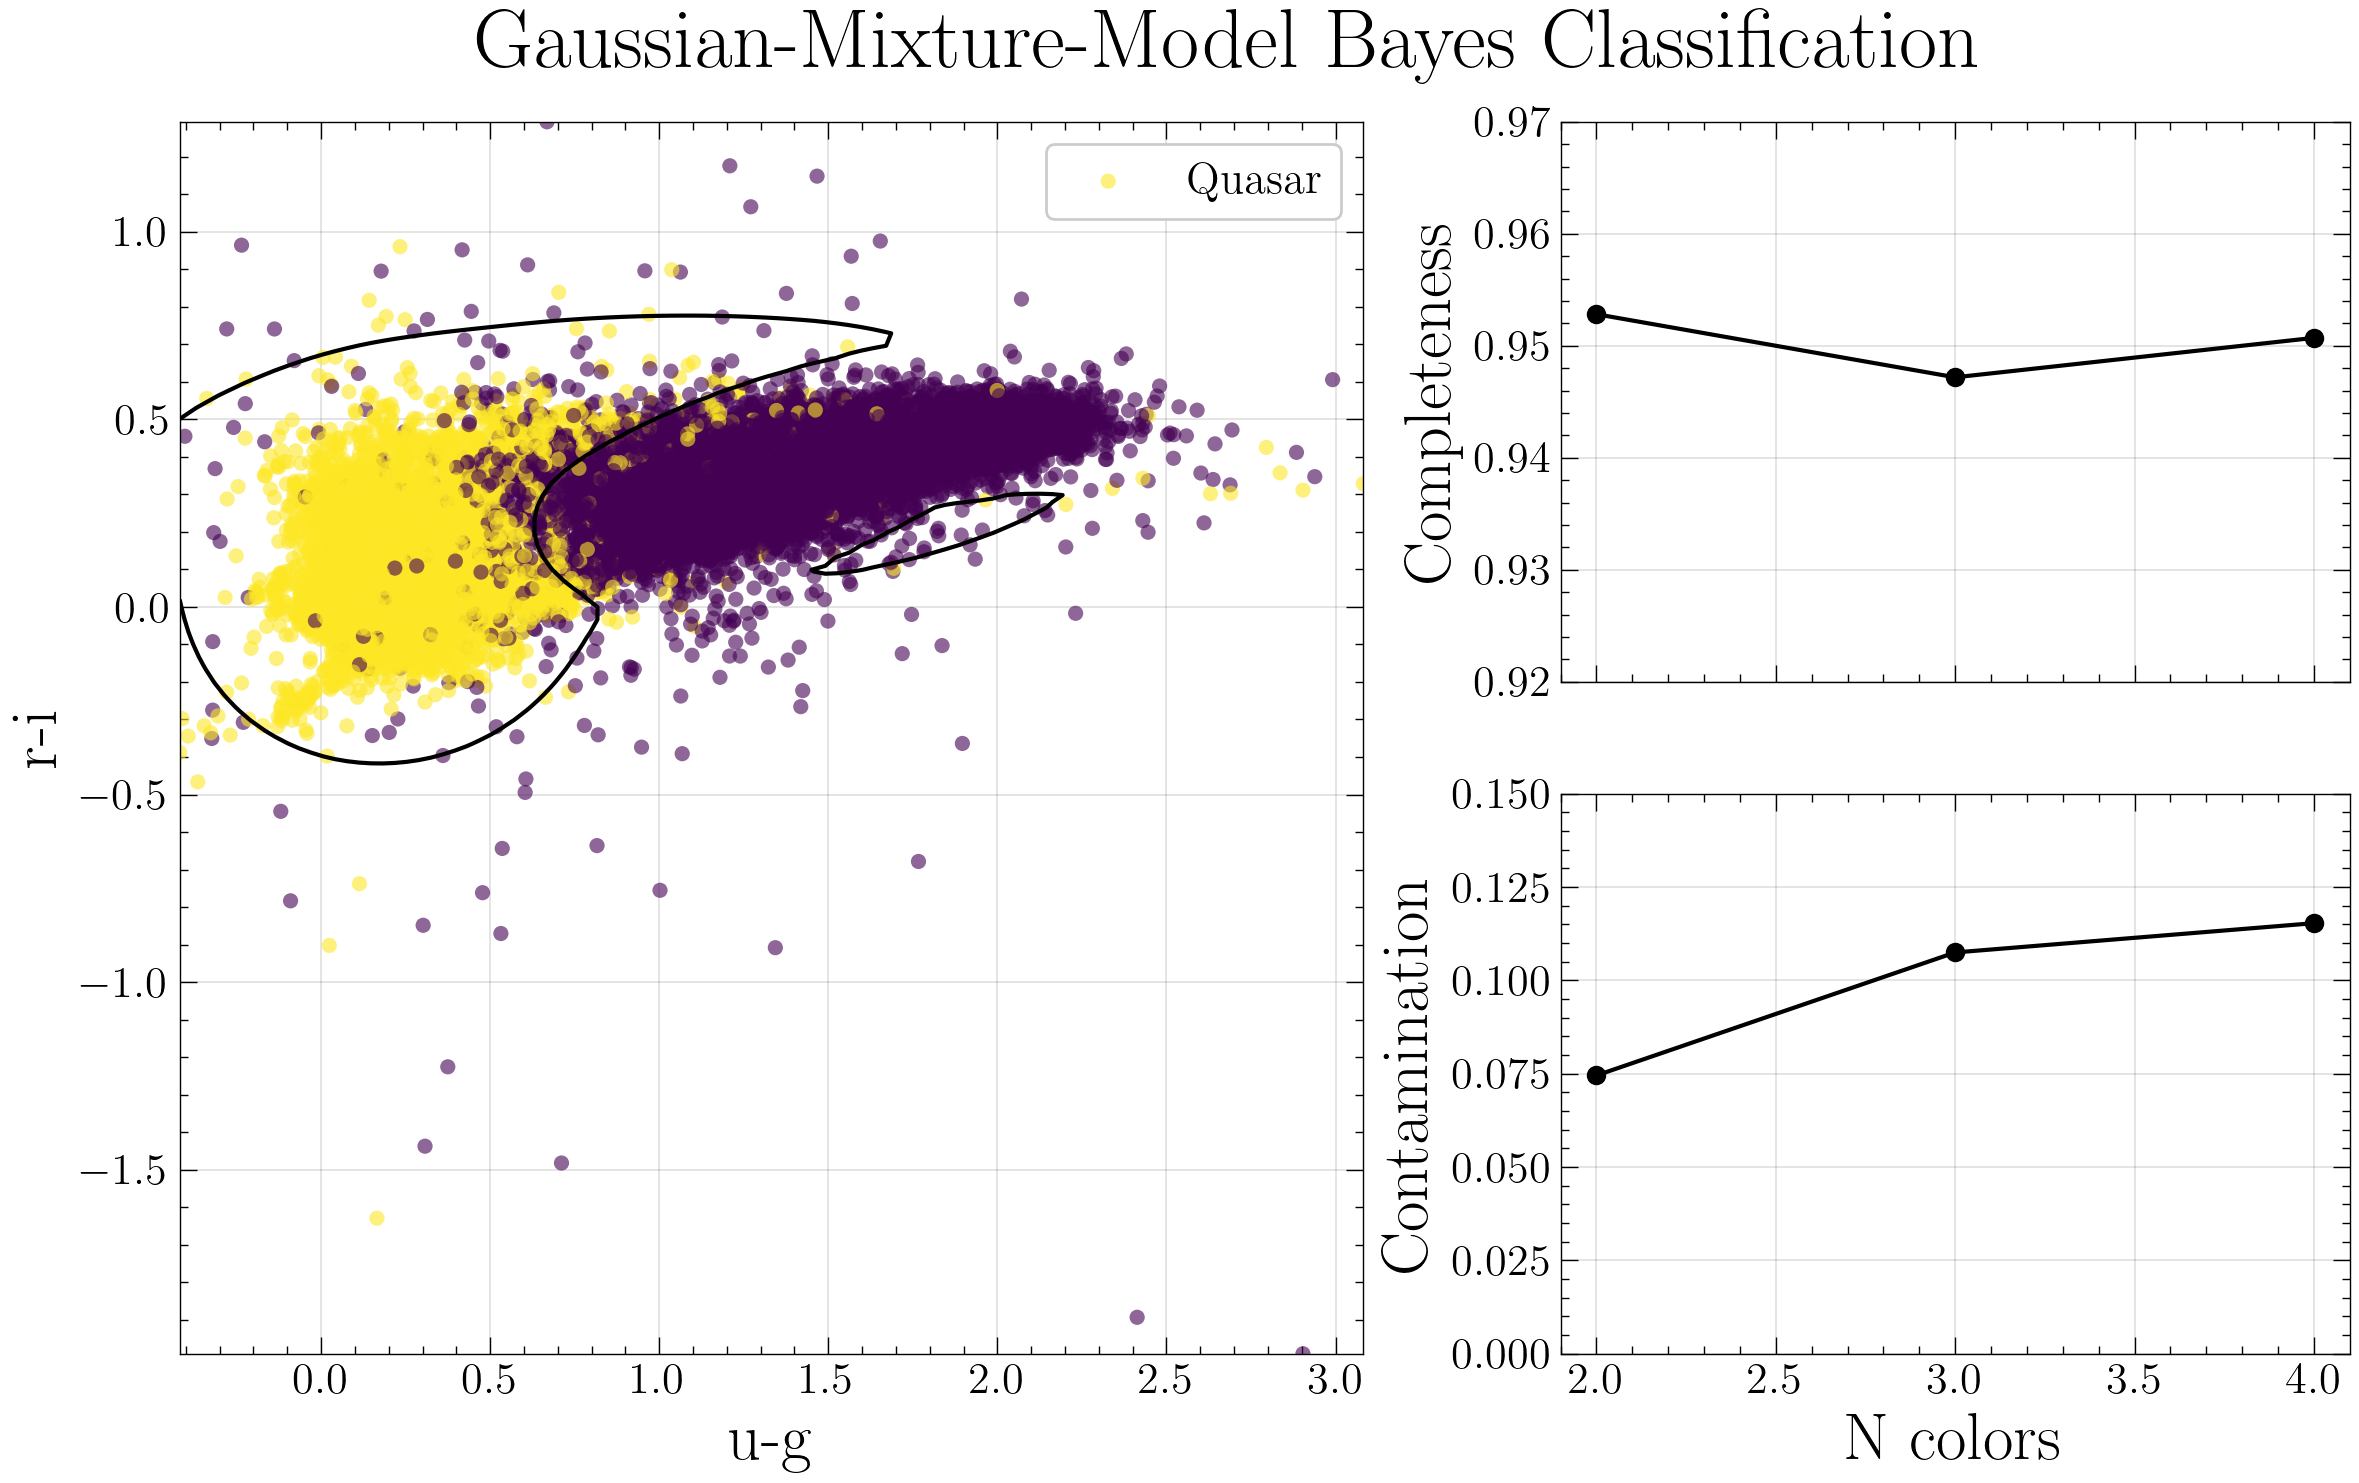

In [14]:
gmmb = GMMBayes(n_components=3)

fig, gmmb_y_pred, gmmb_y_prob, gmmb_completeness, gmmb_contamination = Classify(gmmb, X, X_train, X_test, y_train, y_test)
fig.suptitle('Gaussian-Mixture-Model Bayes Classification', fontsize=30, y=0.95);

### 3.5) K-Nearest Neighbors Classifier

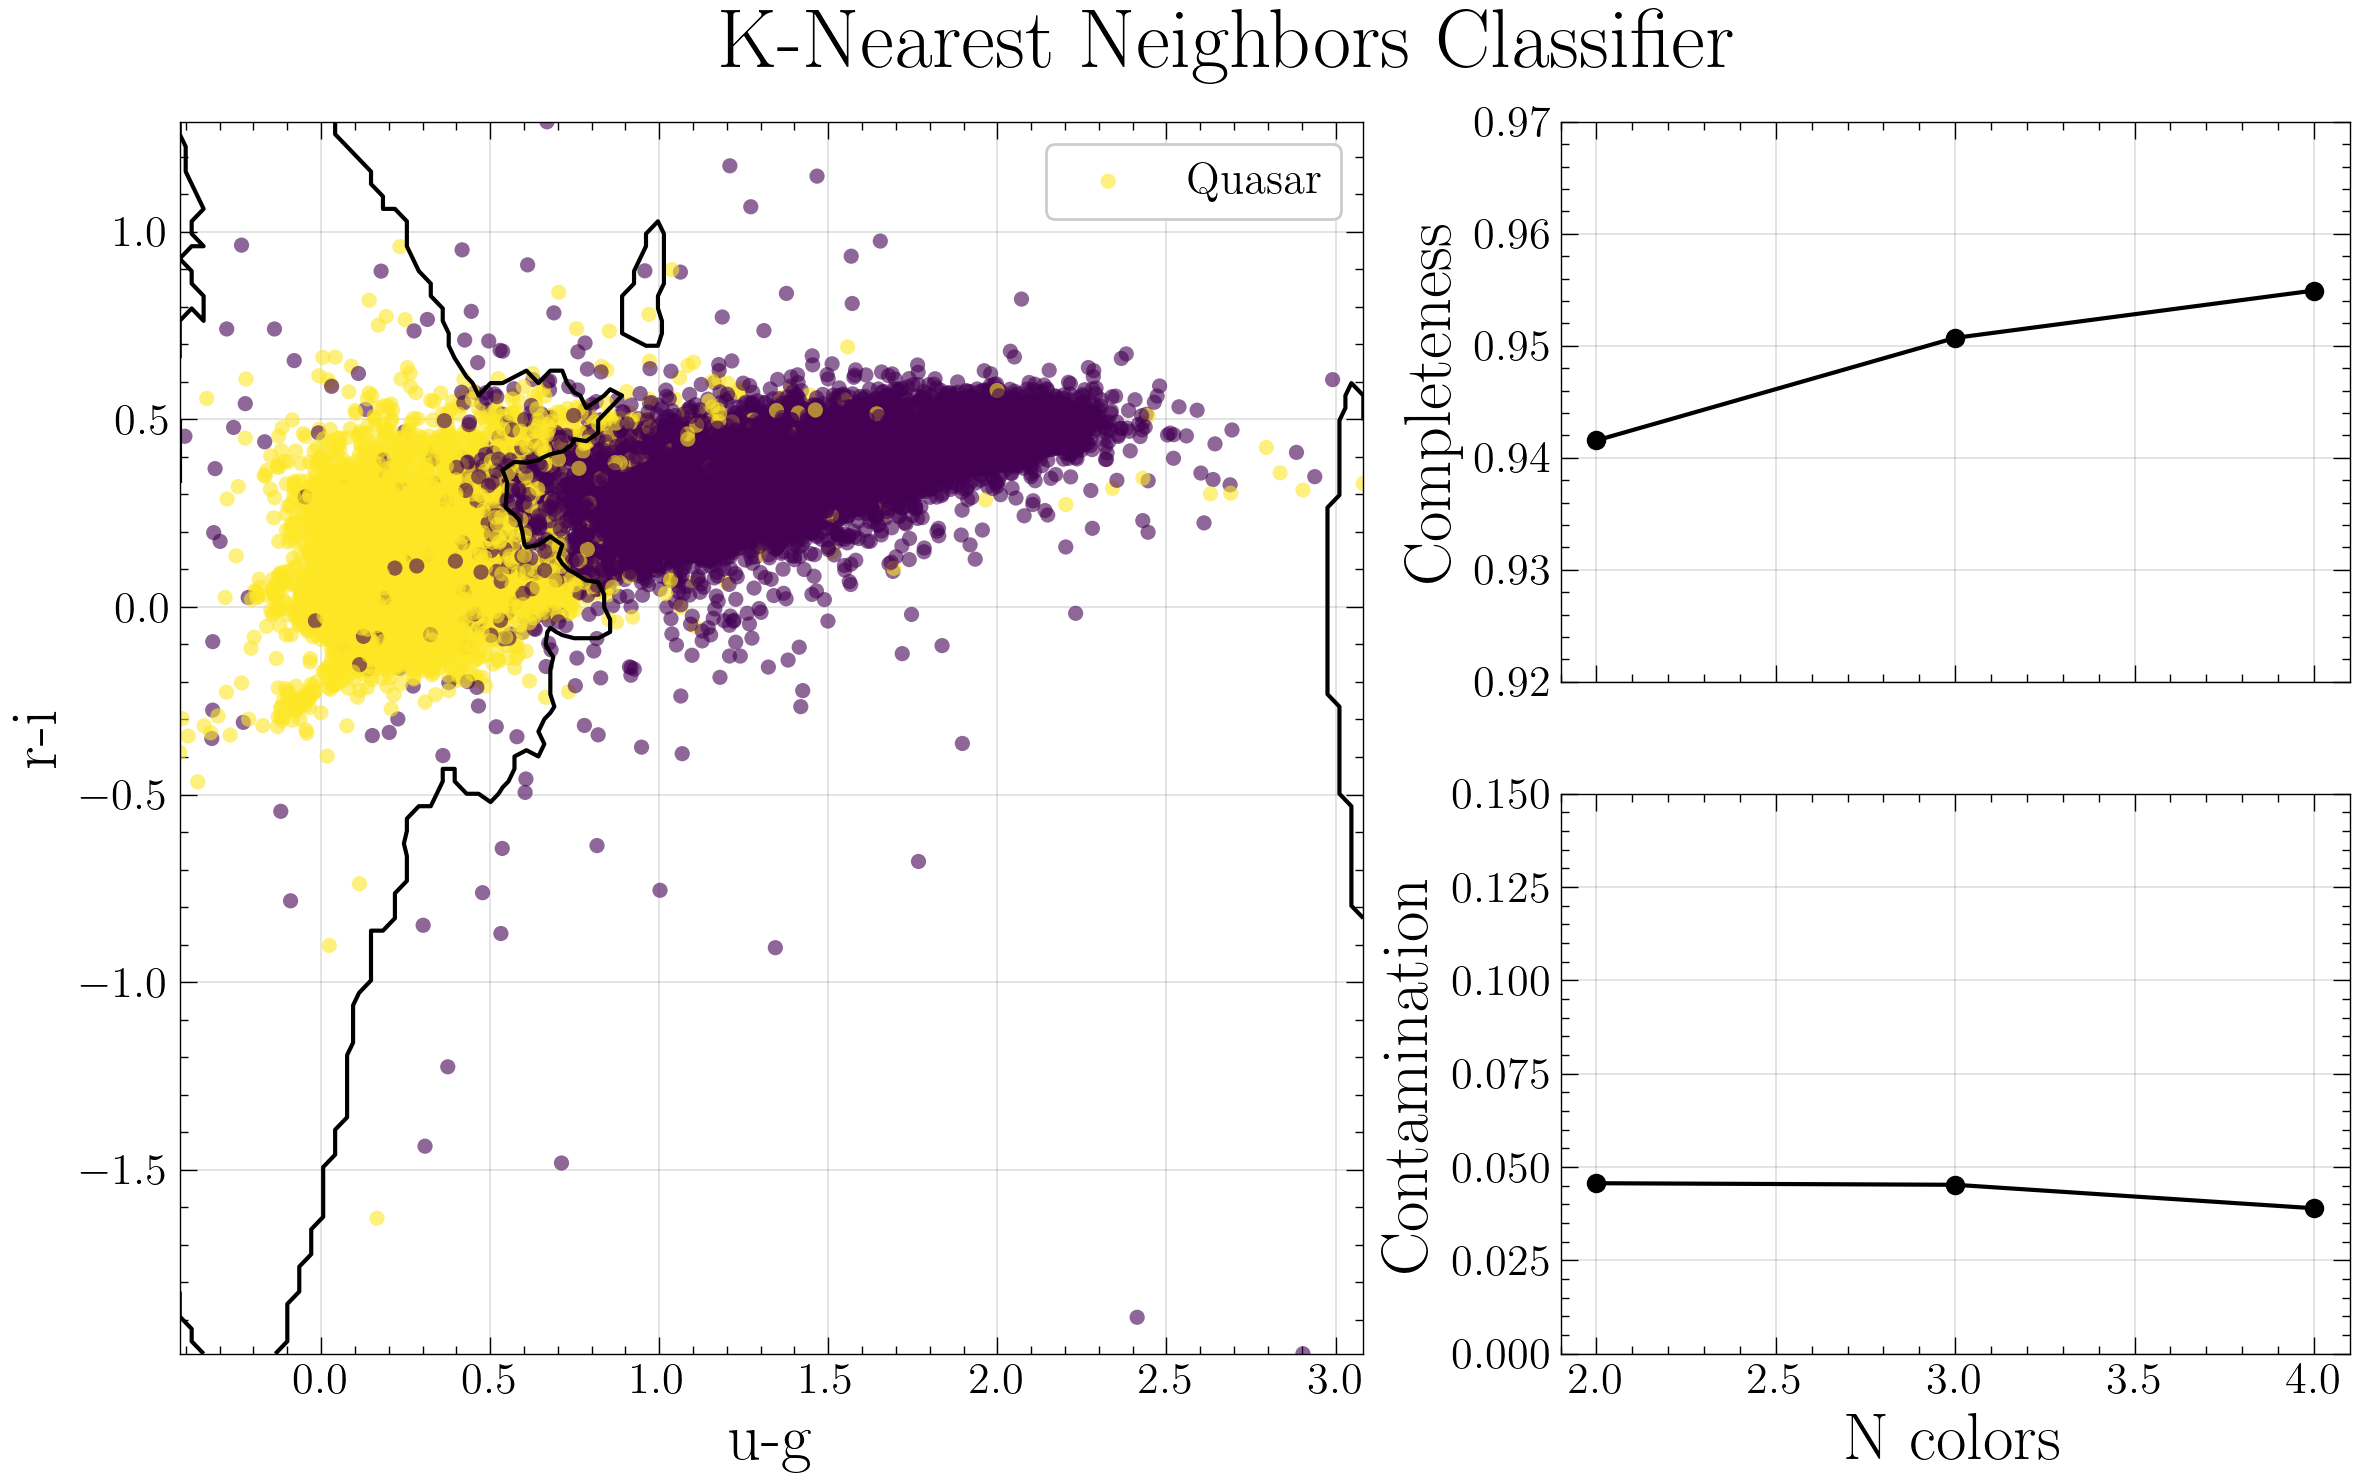

In [15]:
knn = KNeighborsClassifier(n_neighbors=18)

fig, knn_y_pred, knn_y_prob, knn_completeness, knn_contamination = Classify(knn, X, X_train, X_test, y_train, y_test)
fig.suptitle('K-Nearest Neighbors Classifier', fontsize=30, y=0.95);

In this case, `K-Nearest Neighbors` turns out to be the best classifier, both in terms of completeness and contamination.\

The two additional features don't do much: sometimes they improve the result, but others they make it worse! In general, we can obtain a nice result considering just `u-g , r-i`.

## 4) ROC curves

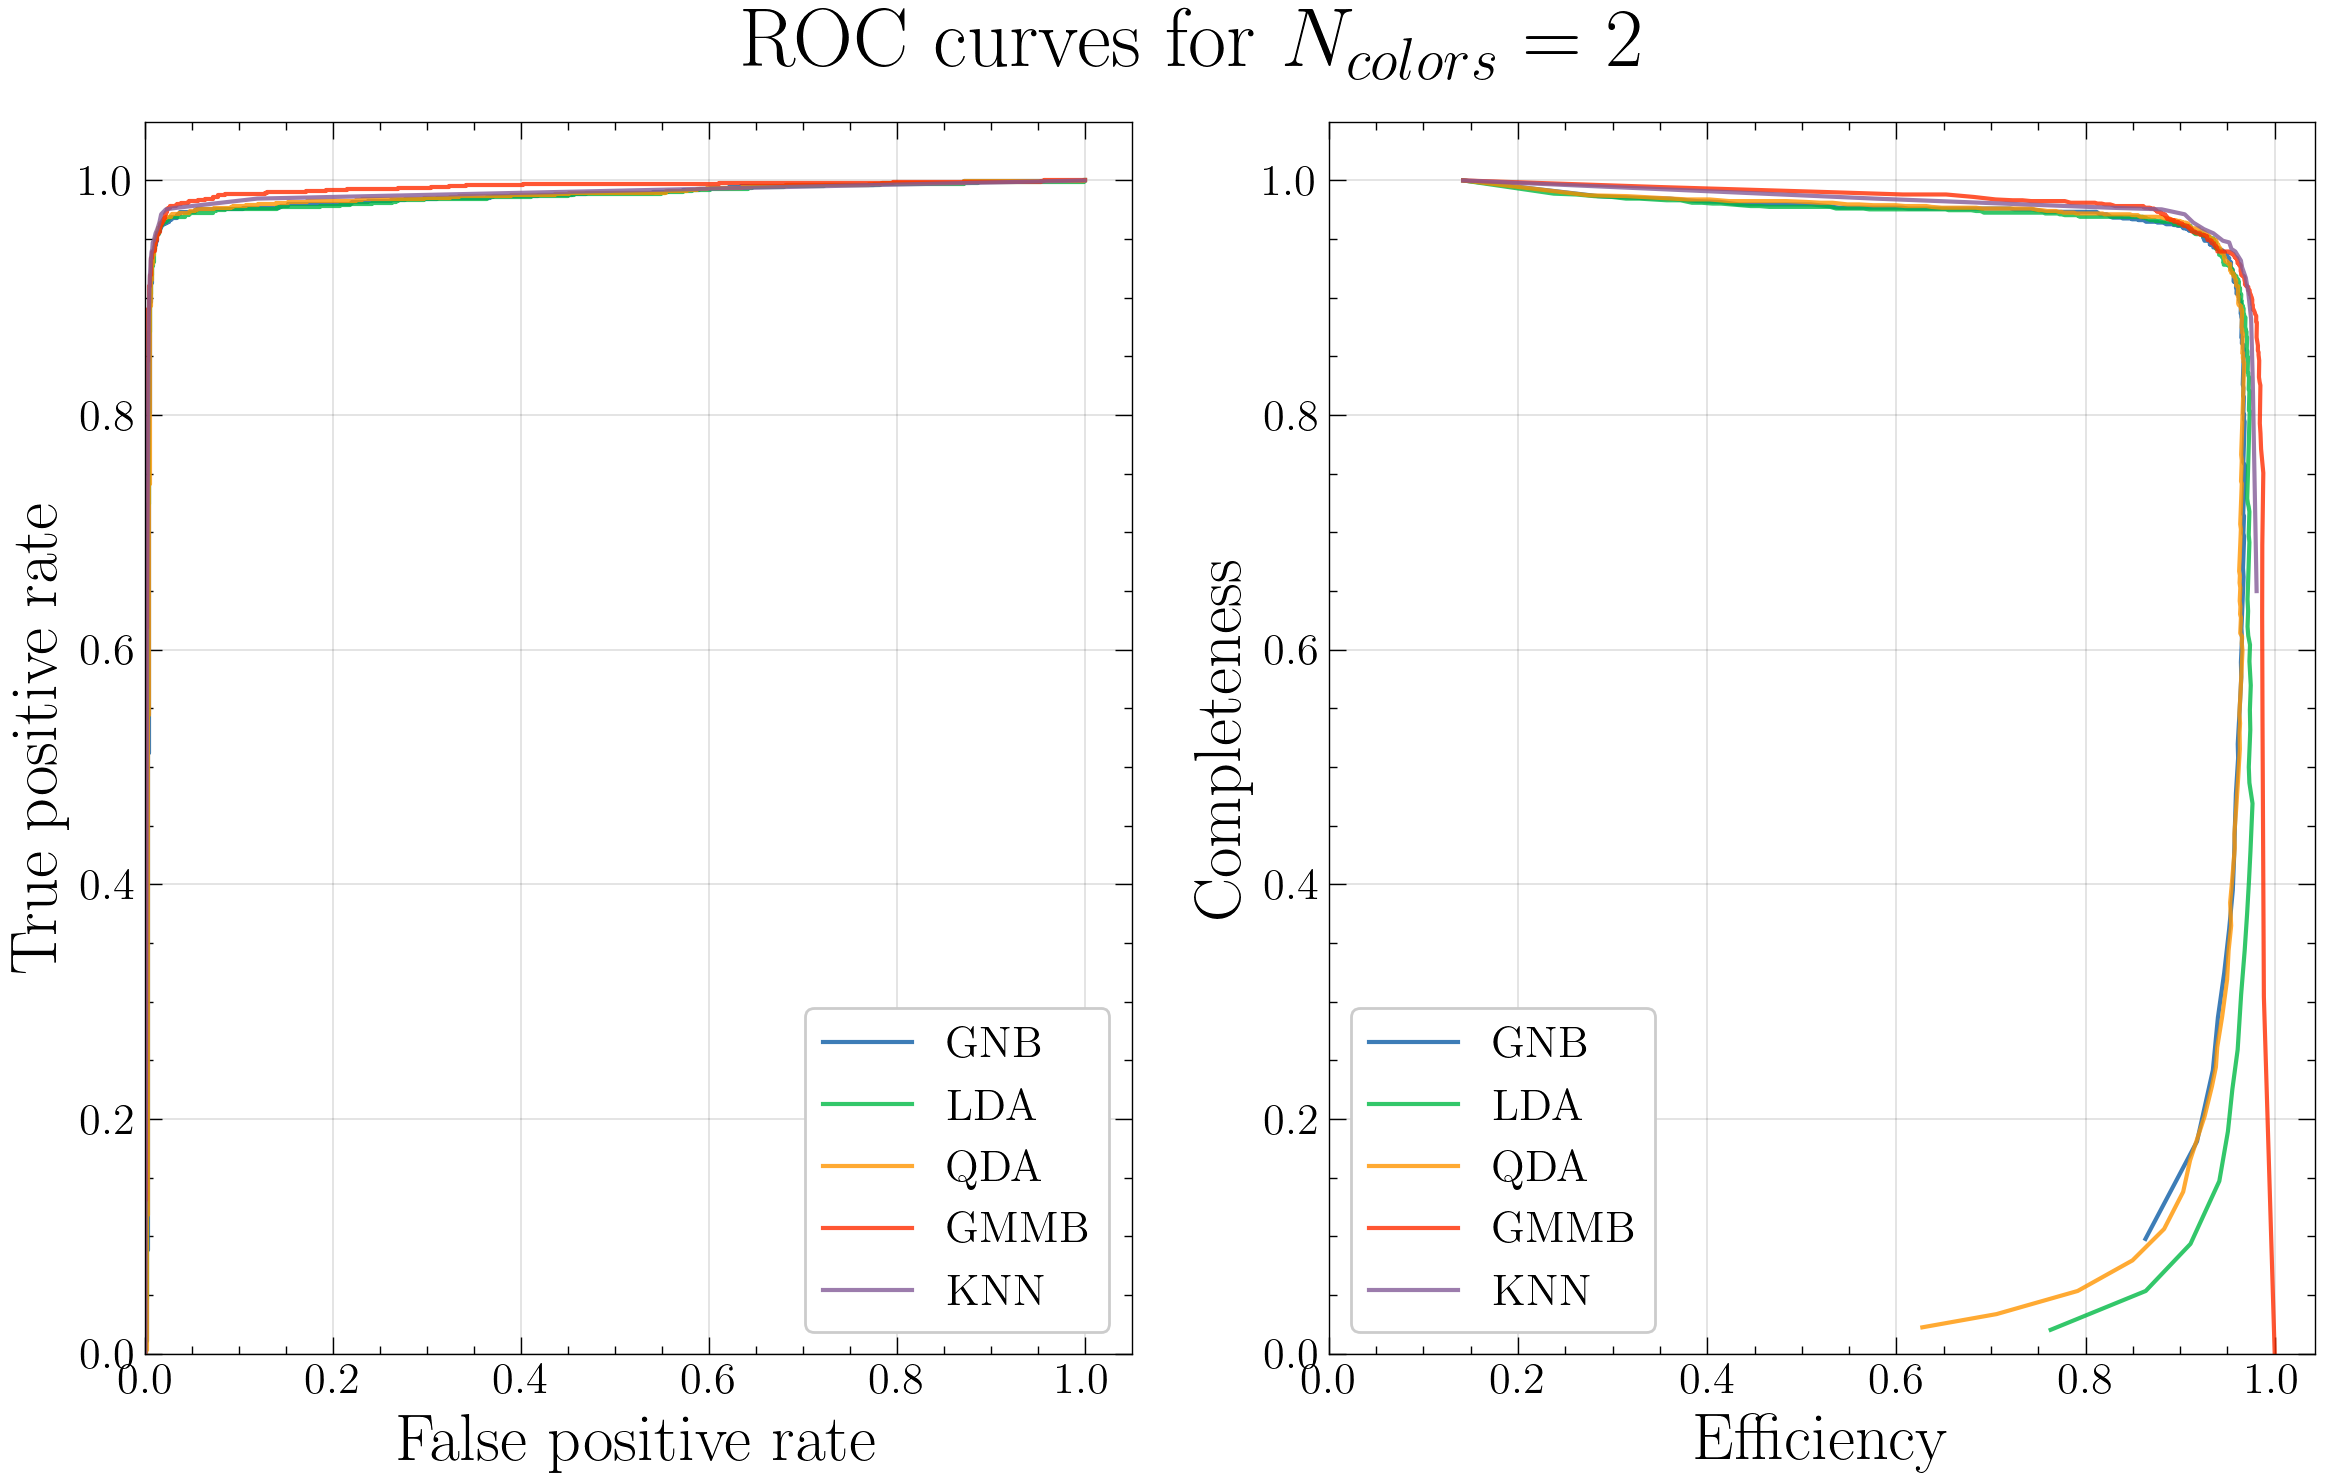

In [18]:
clf_names = np.array(['GNB', 'LDA', 'QDA', 'GMMB', 'KNN'])
y_probs = np.array([gnb_y_prob, lda_y_prob, qda_y_prob, gmmb_y_prob, knn_y_prob])[:,:,0]

fig, axes = plt.subplots(1, 2, figsize=(14,8))
fig.suptitle('ROC curves for $N_{colors}=2$', fontsize=30, y=0.95)

for clf_name, y_prob in zip(clf_names, y_probs):
    # Compute the ROC curve and add (0, 0) as first point
    fpr, tpr, thresh1 = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    # Compute the efficiency-completeness curve and add (1, 0) as first point
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    
    ax = axes[0]
    ax.plot(fpr, tpr, alpha=0.8, label=clf_name)
    
    ax = axes[1]
    thresholds = np.linspace(0, 1, 1001)[:-1]
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred_temp = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred_temp, y_test)
    ax.plot(1 - cont, comp, alpha=0.8, label=clf_name)
    
ax = axes[0]
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend(loc='lower right')

ax = axes[1]
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_xlabel('Efficiency')
ax.set_ylabel('Completeness')
ax.legend(loc='lower left');

The `fpr-tpr curve` is very similar for all the classifier, since we have six times more galaxies than quasars.\
On the other hand, the `efficiency-completeness curve` shows that `GNB`, `LDA` and `QDA` lose efficiency for very low completeness.\
Overall, the five classifiers yield quite similar results.